# The Coolest Superhero According to Cosine Similarity

In the description of this [Superheroes NLP Dataset](https://www.kaggle.com/jonathanbesomi/superheroes-nlp-dataset), the creator Jonathan Besomi has some suggestions of analysis, the first one may be the most interesting and challenging:

> - **Who is the coolest superhero?
Given only the two text columns, can you find a formula to find the coolest superhero?**

In other words, from the descriptions of the history and powers of superheroes, can we rank their coolness? In natural language processing, the popular technique of word embedding springs into my mind. Using high dimensional vectors to represent words and documents, it 
allows us to use cosine similarity to calculate similarity between words and documents. This notebook records the several attempts to do it right, and I will be glad to receive comments and suggestions.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/superheroes-nlp-dataset/superheroes_nlp_dataset.csv


In [2]:
df=pd.read_csv('../input/superheroes-nlp-dataset/superheroes_nlp_dataset.csv')
df

,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,durability_score,...,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
0,3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr.",6,"Delroy Garrett, Jr. grew up to become a track ...",NaN,85,30,60,60,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,514A (Gotham),Bruce Wayne,NaN,10,He was one of the many prisoners of Indian Hil...,NaN,100,20,30,50,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A-Bomb,Richard Milhouse Jones,Richard Milhouse Jones,20,"Richard ""Rick"" Jones was orphaned at a young ...","On rare occasions, and through unusual circu...",80,100,80,100,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Aa,Aa,NaN,12,Aa is one of the more passive members of the P...,NaN,80,50,55,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aaron Cash,Aaron Cash,Aaron Cash,5,Aaron Cash is the head of security at Arkham A...,NaN,80,10,25,40,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,Zatanna,Zatanna Zatara,Zatanna Zatara,10,Zatanna is the daughter of adventurer John Zat...,Zatanna is genetically talented with her magi...,90,10,25,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1446,Zero,DWN-∞: Zero,DWN-∞: Zero,18,Zero was created by the late Dr. Albert Wily ...,NaN,80,100,100,100,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1447,Zoom (New 52),Hunter Zolomon,NaN,20,"Hunter Zolomon is better known as Zoom, a spee...",After tricking Barry Allen and Wally West into...,95,50,100,75,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1448,Zoom,Hunter Zolomon,Hunter Zolomon,9,Hunter Zolomon had a troubled relationship wi...,"Zoom is able to alter time, to make himself ev...",75,10,100,30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 81 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   name                              1448 non-null   object 
 1   real_name                         1301 non-null   object 
 2   full_name                         956 non-null    object 
 3   overall_score                     1450 non-null   object 
 4   history_text                      1360 non-null   object 
 5   powers_text                       1086 non-null   object 
 6   intelligence_score                1450 non-null   int64  
 7   strength_score                    1450 non-null   int64  
 8   speed_score                       1450 non-null   int64  
 9   durability_score                  1450 non-null   int64  
 10  power_score                       1450 non-null   int64  
 11  combat_score                      1450 non-null   int64  
 12  superp

In this analysis we only use the names and the two text columns. As the columns of history_text and powers_text both have more than a hundred null values, I fill them all by "NA".

In [4]:
df.fillna(value={'history_text':'NA', 'powers_text':'NA'}, inplace=True)

In [5]:
df['text']=df.history_text+' '+df.powers_text

In [6]:
hero_text=df[['name','text']]

In [7]:
hero_text

,name,text
0,3-D Man,"Delroy Garrett, Jr. grew up to become a track ..."
1,514A (Gotham),He was one of the many prisoners of Indian Hil...
2,A-Bomb,"Richard ""Rick"" Jones was orphaned at a young ..."
3,Aa,Aa is one of the more passive members of the P...
4,Aaron Cash,Aaron Cash is the head of security at Arkham A...
...,...,...
1445,Zatanna,Zatanna is the daughter of adventurer John Zat...
1446,Zero,Zero was created by the late Dr. Albert Wily ...
1447,Zoom (New 52),"Hunter Zolomon is better known as Zoom, a spee..."
1448,Zoom,Hunter Zolomon had a troubled relationship wi...


# Word Embedding Vector and Cosine Similarity

The nlp library **SpaCy** has the features of word embedding, where every word in their trained model has a vector of 300 dimensions. And it is convenient to use.

In [8]:
import spacy

#load the large model to get word vectors
nlp = spacy.load('en_core_web_lg')

In the vector space of word representation, words of similar meanings are pointing at roughly the same directions, so the cosine of the angle of the two vectors acts as a measure of similarity. We can get the word embedding vectors of the words and use a function to calculate cosine similarity, or use SpaCy's method of **similarity**, which is doing the same thing.

In [9]:
def cosine_similarity(a, b):
    return a.dot(b)/np.sqrt(a.dot(a) * b.dot(b))

In [10]:
cool=nlp('cool').vector
text=nlp('awesome').vector
cosine_similarity(cool, text)

0.7615766

In [11]:
a=nlp('cool')
b=nlp('awesome')
a.similarity(b)

0.7615766136619084

SpaCy also has **most_similar** method to get the list of most similar words to a given word vector. I put it into a function.

In [12]:
def most_similar_list(text_vec, num):
    '''taking the 'text' in vector form and printing the list of most similar words, in which the number is specified by 'num' '''
    queries = np.asarray([text_vec])
    most_similar = nlp.vocab.vectors.most_similar(queries, n=num)
    for i in range(len(most_similar[0][0])):
        print(nlp.vocab.strings[most_similar[0][0][i]].ljust(20), most_similar[2][0][i])

In [13]:
most_similar_list(nlp('cool').vector, 100)

COOL                 1.0
COol                 1.0
cool                 1.0
Cool                 1.0
CooL                 1.0
AWesome              0.7616
Awesome              0.7616
AWESOME              0.7616
AWEsome              0.7616
awesome              0.7616
nICE                 0.7374
nice                 0.7374
NICE                 0.7374
Nice                 0.7374
NIce                 0.7374
PRETTY               0.6568
Pretty               0.6568
pretty               0.6568
PRetty               0.6568
Fun                  0.6487
fun                  0.6487
FUN                  0.6487
kinda                0.6418
Kinda                0.6418
KINDA                0.6418
neat                 0.6415
Neat                 0.6415
NEAT                 0.6415
amaZing              0.6363
amazing              0.6363
AMazing              0.6363
AMAZING              0.6363
Amazing              0.6363
Really               0.632
REALLY               0.632
reAlly               0.632
REALLy    

The word "cool" has multiple meanings of many subtle overtones. In popular usages when we say someone is cool, we usually mean he or she is hip, fashionable, excellent, composed, uniquely at their own, but it can also refer to not enthused, dispassionate and unfriendly, and also moderately cold temperature. The 100 most similar words of cool in SpaCy's large English model have "cool" in different spellings at the tops, then followed by "awesome", "nice", "pretty" and "fun", which are closer to hip and excellent.

In [14]:
wordlist=['cool','cold','coolest','awesome','amazing','chill','confidence','composed','calm','nonchalant','Batman','Superman','nerd','geek',
          'uncool','hot','ice','fashion']
for word in wordlist:
    wordvec=nlp(word).vector
    print(word.ljust(20), cosine_similarity(cool, wordvec))

cool                 1.0
cold                 0.5644185
coolest              0.608426
awesome              0.7615766
amazing              0.6363099
chill                0.6075392
confidence           0.16269511
composed             0.19751108
calm                 0.44255415
nonchalant           0.24065392
Batman               0.36020163
Superman             0.31441408
nerd                 0.421054
geek                 0.4376547
uncool               0.33795375
hot                  0.5611704
ice                  0.41151524
fashion              0.37175122


And the similarity scores of other words show the side of composed, nonchalant and confidence in cool is ranked low in SpaCy's large English model. While "nerd" and "geek" are regarded as opposite to cool, their relatively higher similarity scores (above 0.4) are attributed to the fact that they are talked more often together with cool than other unrelated topics. And one interesting thing is "Batman" has a higher similar score then "Superman", perhaps reflecting in common sayings Batman is cooler than Superman.

And for vector representation of sentences, paragraphs and even documents, SpaCy follows the conventional method of using centroid vectors, meaning taking the mean of all tokenized words(including punctuations) of the sentence, paragraph and document. Generally speaking, sentences or paragraphs which contain more of the word "cool" or similar meaning words should get higher cosine similarity scores.

In [15]:
b = nlp('he is very awesome. she is nice and amazing.')
print(b.similarity(nlp('cool')))

0.6795831640320981


The next two paragraphs for testing are taken from an article on the meaning of cool, while the third one is taken from a news article. And the first two paragraphs do have higher similarity scores with the word 'cool' than the third one.

In [16]:
b = nlp("It’s tough to define the exact qualities that make someone cool, since pretty much everyone has a different idea of what 'cool' is. For some, it’s a leather-coat-wearing motorcyclist on an open road. For others, it’s the lead singer of a band, an English major surrounded by books, or a really chic neighbor who always burns the best incense. These people are wildly different, and yet they can all be considered cool because they project something special — a certain je ne sais quoi — that makes them stand out.")
print(b.similarity(nlp('cool')))

0.6362329653887256


In [17]:
b = nlp('You know you’re in the presence of a cool person when you feel at ease. The reason? “Cool people are present, focused, and interested in those around them,” Romanoff says. They listen, they try to understand — and as a result, they help everyone feel seen and understood.')
print(b.similarity(nlp('cool')))

0.5910140438438523


In [18]:
b = nlp('Her visit comes after three high-level diplomatic meetings last week ended with Russian troops still on Ukraine’s borders, but no definitive sign whether Putin would risk a military incursion or instead start talks with the US about arms control in Europe, a more limited agenda than his call for a redrawing of the security architecture of Europe.')
print(b.similarity(nlp('cool')))

0.48815137638105816


# First Attempt: Ranking the Raw Texts by Cosine Similarity Scores with the Word "Cool"

For now it seems to be a promising approach. So a simple way of determining who is the coolest superhero is to get each one's text description tokenized and get the centroid vector, then calculate the cosine similarity with the word "cool" as a "cool score" and get them ranked. Is it that simple? Let's see how it goes.

In [19]:
with nlp.disable_pipes():
    hero_text['cool_score']=hero_text.apply(lambda r: nlp('cool').similarity(nlp(str(r.text))), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
hero_text.sort_values(by='cool_score', ascending=False).head(10)

,name,text,cool_score
1071,Red Mist,The Red Mist was another teenager following th...,0.592707
615,Hulk (Stark Gauntlet) (MCU),After Tony created a new gaunlet Hulk uses it ...,0.592674
126,Batgirl (New 52),NA Barbara is very intellegent she is one of t...,0.590817
758,Kool-Aid Man,Before he was officially the Kool-Aid Man in 1...,0.589922
1332,Trickster II,Axel Walker was the second villain to be calle...,0.585122
852,Mario,Early Life The Stork was carrying Mario and Lu...,0.583821
542,Green Goblin (2099),The Goblin of the year 2099 wanted to take Spi...,0.583415
1055,Rainbow Rider,Roy G. Bivolo was a daltonic kid whose parents...,0.583311
713,Kai (The LEGO Ninjago Movie),"Kai's attitude is more serious, like Cole in t...",0.581369
627,Iceman (FOX),"Bobby lived with his mother, father and younge...",0.578471


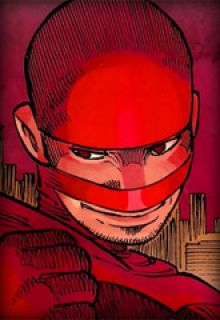

In [21]:
#codes adapted from Jonathan Besomi
Red_Mist = df.query("name == 'Red Mist'")
Red_Mist_img = "https://www.superherodb.com" + Red_Mist['img'].values[0]

import requests
import IPython.display as Disp
Disp.Image(requests.get(Red_Mist_img).content)

So for this first trial, the Red Mist is the coolest superhero. I make a function to display the text description of selected superhero and also the tokens in the text that have highest similarity scores with the word "cool". In the case of Red Mist, there is a direct reference stating he has "cooler appearance", but stop words like "but" and "some" also get moderately high similarity scores.

In [22]:
def print_content_and_top_words(df, column, row):
    b=nlp(df.loc[row, column])
    a=nlp('cool')
    token_similarity=pd.DataFrame([token, token.similarity(a)] for token in b if token.has_vector)
    token_similarity.columns=['token','similar_score']
    print(df.loc[row, column])
    display(token_similarity.sort_values(by='similar_score', ascending=False).head(10))

In [23]:
print_content_and_top_words(hero_text, 'text', 1071)

The Red Mist was another teenager following the example of Kick-Ass. But his cooler appearance stole some Kick-Ass fandom. Trying to settle things right, Dave tried to talk to him and force Red Mist to give up his super hero identity but in the end they decided to team-up when a building was on fire.   When Kick-Ass was visited by Hit-Girl and Big Daddy, Red Mist was reluctant to join their team. Both friends were in they way to meet Hit-Girl and her father in their headquarters ready to make a counter offer. But what they saw was a heavenly wounded Big Daddy pleading for help at the hands of Johnny G. At that precise moment, Red Mist was exposed not only as a traitor who set the heroes up but as Johnny G's son. NA


,token,similar_score
45,super,0.600200
16,cooler,0.587706
93,way,0.548841
14,But,0.536709
48,but,0.536709
112,But,0.536709
150,but,0.536709
19,some,0.524228
28,things,0.522775
107,make,0.518917


In [24]:
print_content_and_top_words(hero_text, 'text', 615)

After Tony created a new gaunlet Hulk uses it to revive everyone. NA


,token,similar_score
8,it,0.541804
11,everyone,0.523846
3,a,0.411081
4,new,0.409951
12,.,0.391355
9,to,0.380088
2,created,0.333128
7,uses,0.301719
0,After,0.267998
1,Tony,0.250260


In [25]:
print_content_and_top_words(hero_text, 'text', 126)

NA Barbara is very intellegent she is one of the smartest dc characters . She is also a very good fighter and has many gadgetsand weapons.


,token,similar_score
19,good,0.594249
3,very,0.587075
18,very,0.587075
7,one,0.455783
17,a,0.411081
15,is,0.399207
2,is,0.399207
6,is,0.399207
13,.,0.391355
25,.,0.391355


The second placed Hulk (Stark Gauntlet) (MCU) and third placed Batgirl (New 52) fare worse. Both descriptions are extremely short, but with some common words which have fairly high similarity scores with "cool" like "it", "everyone", "good" and "very", they are ranked high in "cool score". It is not convincing, and indicates that the current approach of getting centroid vector to represent a text in it's raw state is discriminating against long descriptions. A long text may say about ten things about a superhero, while it may have some good words on coolness, but the talk of other nine things dilutes so much that the whole text gets a low similarity score. 

# Second Attempt: TF-IDF Weighted Document Embedding Vectors

A better approach may be to clean the text first and suppress the weighing of words that are common across documents by means like TF-IDF. In creating TF-IDF weighted word embeddings for documents, I adopt the codes of [John Cardente](http://dsgeek.com/2018/02/19/tfidf_vectors.html).

In [26]:
def keep_token(t):
    '''filter out spaces, punctuation marks, stop words and numbers'''
    return (t.is_alpha and 
            not (t.is_space or t.is_punct or 
                 t.is_stop or t.like_num))

def lemmatize_doc(doc):
    '''lemmatize the words'''
    return [ t.lemma_ for t in doc if keep_token(t)]

docs = [lemmatize_doc(nlp(doc)) for doc in hero_text.text]  #create the list of all cleaned text

In [27]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

docs_dict = Dictionary(docs)  #create a mapping between words and their integer ids.
docs_dict.filter_extremes(no_below=1, no_above=0.2) #filters common words that appear in more than 20% of documents
docs_dict.compactify()

In [28]:
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs] #create a bag-of-words representation of each document
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict, smartirs='bfu') 
#build the TF-IDF model, using binary term frequency weighing ('b'), inverse document frequency weighing('f') and pivoted unique document normalization('u')
docs_tfidf  = model_tfidf[docs_corpus] 
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf]) #compute the TF-IDF vector for each document
tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))]) #get the word embedding vector for each TF-IDF term
docs_emb = np.dot(docs_vecs, tfidf_emb_vecs)  #get the TF-IDF weighted word embedding vector summary of each document

Then we use the TF-IDF weighted document embedding vectors to calculate cosine similarity scores for a second attempt of coolness ranking.

In [29]:
cool_score2=[cosine_similarity(docs_emb[i], nlp('cool').vector) if np.any(docs_emb[i]) else 0 for i in range(len(docs_emb))]
hero_text['cool_score2']=pd.Series(cool_score2)
hero_text.sort_values(by='cool_score2', ascending=False).head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,text,cool_score,cool_score2
1071,Red Mist,The Red Mist was another teenager following th...,0.592707,0.637795
758,Kool-Aid Man,Before he was officially the Kool-Aid Man in 1...,0.589922,0.620743
627,Iceman (FOX),"Bobby lived with his mother, father and younge...",0.578471,0.613987
504,Garmadon (The Lego Ninjago Movie),"At some point, Garmadon met Koko in a battle, ...",0.559985,0.612198
713,Kai (The LEGO Ninjago Movie),"Kai's attitude is more serious, like Cole in t...",0.581369,0.590670
733,Kick-Ass,Dave Lizewski lead a typical high school life....,0.563058,0.590288
812,Lloyd (The LEGO Ninjago Movie),"Lloyd was born to Lord Garmadon and Koko, some...",0.566117,0.589230
600,Hit-Girl,Hit-Girl (she has not yet been called by anoth...,0.543267,0.585460
531,GPL,The IT Guys had the idea of making the Garma M...,0.554245,0.583137
659,Jack Frost,Before Jack Frost became an immortal being who...,0.556214,0.582539


And I adapt the codes of [Nathan Kelber](https://ithaka.github.io/tdm-notebooks/finding-significant-terms.html) for displaying the top 20 tokens in selected document by their TF-IDF scores, and their cosine similarity score and also their products with respect to a stated text(in this case 'cool') in embedded vector form.

In [30]:
def most_important_terms(index, text_vec):

    def Sort(tfidf_tuples):
        '''Sort the tuples in the tf-idf scores list, based on the second value in the tuple, the tf-idf score'''
        tfidf_tuples.sort(key = lambda x: x[1], reverse=True)
        return tfidf_tuples 

    # List the top twenty tokens in the selected document by their TF-IDF scores
    most_significant_terms = Sort(docs_tfidf[index])[:20]
    
    print('term'.ljust(20), 'TF-IDF Score'.ljust(20), 'Cosine Similarity'.ljust(20), 'TF-IDF*Cosine Similarity')
    
    for id, score in most_significant_terms:
        cosine_score = cosine_similarity(nlp(docs_dict[id]).vector, text_vec)
        print(docs_dict[id].ljust(20), str(score).ljust(20), str(cosine_score).ljust(20), score*cosine_score)
        # Display the token, its TF-IDF score, cosine similarity score and their product with stated text in vector

In this second attempt, Red Mist is still ranked top, apparently factored significantly by the word "cooler".  Hulk (Stark Gauntlet) (MCU) and Batgirl (New 52) drop out from the top 10, but the inclusions of Kool-Aid Man, Iceman and Jack Frost reflect that terms related to temperature like "kool", "ice", "snow", "cold" come into focus, which is not the sense of "cool" we are talking about.

In [31]:
most_important_terms(1071, nlp('cool').vector)

term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
fandom               0.06825090388327139  0.24340743           0.016612776990962714
cooler               0.05795031348268659  0.5877062            0.034057759002595396
Ass                  0.05795031348268659  0.38833052           0.02250387532249801
G                    0.05525300595710841  0.13753474           0.007599207675202477
heavenly             0.05525300595710841  0.264263             0.014601325337822494
Kick                 0.053160811698653394 0.3664973            0.01948329437949256
Hit                  0.0514513645196051   0.32628635           0.016787877711424593
Dave                 0.0514513645196051   0.31395507           0.016153416676712024
Daddy                0.04764972308210179  0.33185068           0.015812592898378115
Mist                 0.043507098560481926 0.35724276           0.01554259610170676
precise              0.039269285389395725 0.24971089           0.0098059681

In [32]:
display(hero_text.text[758])
print()
most_important_terms(758, nlp('cool').vector)

'Before he was officially the Kool-Aid Man in 1975, he was the “Pitcher Man”. The Pitcher Man was created in 1954 by Marvin Plotts, an art director for a New York-based advertising agency. General Foods had just purchased Kool-Aid from the drink’s creator Edwin Perkins the year before, and Plotts was charged with drafting a concept to illustrate the copy message: “A 5-cent package makes two quarts. " Working from his Chicago home on a cold day, Potts watched as his young son traced smiley face patterns on a frosty windowpane," recounts Sue Uerling, marketing and communications director for Hastings Museum of Natural and Cultural History. This inspired Marvin Plotts to create a beaming glass pitcher filled with flavorful drink: the Pitcher Man. From there on the joyful pitcher was on all the Kool-Aid’s advertisements. the voice of the man is John Fickley. In 1975 Kraft Foods created the character’s first costume with arms and legs. He also became more of an action figure in commercials 


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
Aid                  0.060925765262218344 0.16466914           0.010032593441059392
Cola                 0.060925765262218344 0.2699041            0.016444114257580338
Cultural             0.060925765262218344 0.18840528           0.011478735579823861
Fickley              0.060925765262218344 nan                  nan
Fierce               0.060925765262218344 0.32453394           0.019772478609166155
Foods                0.060925765262218344 0.23441777           0.014282081804875143
Kool                 0.060925765262218344 0.5290418            0.03223227814894292
Kraft                0.060925765262218344 0.1179654            0.007187132282804218
Perkins              0.060925765262218344 0.0036381646         0.0002216579627671374
Pitcher              0.060925765262218344 0.165058             0.0100562850769405
Plotts               0.060925765262218344 nan                  nan
Uerling              0.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


In [33]:
display(hero_text.text[627])
print()
most_important_terms(627, nlp('cool').vector)

"Bobby lived with his mother, father and younger brother, eventually he began to display mutant abilities but he kept it from them out of fear. He convinced his parents to send him to a fancy prep school but in reality he went to Xavier's School for Gifted Youngsters. He felt like he belonged and became good friends with Pyro. Iceman possesses the ability to manipulate and generate both cold and ice from his body. He used this ability to freeze various things as well as project ice from his hands. The ice he generates is can be brittle like glass or hard like stone. He can also shoot freezing cold, coolant-like gas or aura from his body that can cause ice to form on whatever it comes into contact with it. With his power over cold, he can reduce temperature to freezing points, to the point where he could turn a ball of fire Pyro created into a ball of brittle"


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
prep                 0.06836197412849053  0.21300067           0.014561146297046775
brittle              0.061852448897346264 0.22051059           0.013639119819692418
coolant              0.058044620739628655 0.2370694            0.013760603305444881
fancy                0.055342923666202    0.488408             0.02702992662195581
Pyro                 0.04883339843505775  0.19866158           0.009701320123172751
Bobby                0.04121774211962252  0.24790552           0.01021810589993529
Iceman               0.038915733440893115 0.12840138           0.004996834023752244
Youngsters           0.038915733440893115 0.20826104           0.008104631229024226
Gifted               0.038516045046195865 0.23666036           0.009115221136093782
aura                 0.034708216888478256 0.28318304           0.009828778310188569
belong               0.03395651502806086  0.1987843            0.00675002

In [34]:
display(hero_text.text[659])
print()
most_important_terms(659, nlp('cool').vector)

"Before Jack Frost became an immortal being who possessed the power over ice and snow, Jack was once a teenage human boy who had a family of his own 300 years before the current timeline. Like his current form, Jack was mischievous, liked to have fun and play tricks on his friends and his younger sister. When Jack and his sister got themselves in trouble while they were ice skating on thin ice, Jack made up a game of Hopscotch, and using his staff, Jack saved his sister from the cracking ice, at the cost of his own life.   The Man in the Moon, seeing Jack's selfless act of heroism and sacrifice, shines his light and transforms Jack into a Winter Spirit, of which Jack rises up from the frozen pond and he is reborn as Jack Frost. When Jack Frost was reborn he lost all memory of his previous life and immediately began his adventures of fun and mischief, discovering his powers. The Man in the Moon only ever told him his name, and he quickly discovers no one can see him when he enters a vil


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
Hopscotch            0.06770092283048533  0.04172384           0.0028247424678774285
skating              0.06770092283048533  0.31288695           0.02118273548367682
mischievous          0.061254343852112494 0.19329643           0.01184024614144256
selfless             0.061254343852112494 0.1211248            0.007419419938075981
mischief             0.05480776487373965  0.1570234            0.008606101590617614
pond                 0.05273242998469117  0.31095636           0.016397484424495345
shine                0.04836118589536682  0.34952822           0.016903599381534604
Spirit               0.0445901789350814   0.3223436            0.014373358261938715
snow                 0.042514844046032924 0.41986823           0.01785063235318339
heroism              0.04135077080320078  0.052609086          0.002175426258868713
Winter               0.040819171974795995 0.43268427           0.01766181

# Third Attempt: Refining the Vector of "Cool"

This brings us to the other cool property of word embedding vectors. When a vector space model is well trained, it can capture the semantic structure of words, so that word pairs become parallel vectors that can perform arithmetic operations. If we use "|word|'' to denote a word vector, the famous examples are:

> **|King|-|man|+|woman|=|Queen|**

> **|Paris|-|France|+|Germany|=|Berlin|**

When we perform the same arithmetics on SpaCy's word embedding vectors, the closest words for the resulting vectors are in fact "King" and "Germany", but "Queen" and "Berlin" come as the close second.

In [35]:
king=nlp('king').vector
man=nlp('man').vector
woman=nlp('woman').vector
most_similar_list(king-man+woman, 10)

KIng                 0.8024
King                 0.8024
king                 0.8024
KING                 0.8024
Queen                0.7881
queen                0.7881
QUEEN                0.7881
PRINCE               0.6401
prince               0.6401
Prince               0.6401


In [36]:
paris=nlp('paris').vector
france=nlp('france').vector
germany=nlp('Germany').vector
most_similar_list(paris-france+germany, 10)

Germany              0.8028
GERMANY              0.8028
germany              0.8028
BERLIN               0.7547
Berlin               0.7547
berlin               0.7547
paris                0.6961
PARIS                0.6961
Paris                0.6961
FRANKFURT            0.6708


How about subtracting "cold" from "cool"? The closest word becomes "kewl", the alternative spelling of "cool" in slang, but with cosine similarity score of only 0.4408, "cool" features even lower in 0.3774. But when we add one more vector of "cool" to it, the most similar word becomes "cool" again.

In [37]:
cool=nlp('cool').vector
cold=nlp('cold').vector
most_similar_list(cool-cold, 50)

Kewl                 0.4408
KEWL                 0.4408
kewl                 0.4408
AWESOME              0.4206
AWEsome              0.4206
awesome              0.4206
Awesome              0.4206
AWesome              0.4206
AWSOME               0.3894
Awsome               0.3894
awsome               0.3894
coool                0.3781
COOOL                0.3781
Coool                0.3781
COol                 0.3774
CooL                 0.3774
cool                 0.3774
COOL                 0.3774
Cool                 0.3774
COOLEST              0.3764
Coolest              0.3764
coolest              0.3764
THx                  0.3624
Thx                  0.3624
THX                  0.3624
thx                  0.3624
KickAss              0.3532
KICKASS              0.3532
Kickass              0.3532
kickass              0.3532
Groovy               0.3474
groovy               0.3474
GROOVY               0.3474
^_^                  0.3438
AVATAR               0.343
avatar               

In [38]:
most_similar_list(cool*2-cold, 50)

CooL                 0.8318
COol                 0.8318
cool                 0.8318
COOL                 0.8318
Cool                 0.8318
AWEsome              0.7133
awesome              0.7133
AWesome              0.7133
Awesome              0.7133
AWESOME              0.7133
NICE                 0.6181
nice                 0.6181
Nice                 0.6181
nICE                 0.6181
NIce                 0.6181
AWSOME               0.6085
awsome               0.6085
Awsome               0.6085
Kewl                 0.5965
kewl                 0.5965
KEWL                 0.5965
coolest              0.5941
COOLEST              0.5941
Coolest              0.5941
fun                  0.5787
FUN                  0.5787
Fun                  0.5787
Amazing              0.5775
AMAZING              0.5775
AMazing              0.5775
amaZing              0.5775
amazing              0.5775
neat                 0.5757
Neat                 0.5757
NEAT                 0.5757
CUTE                

In [marketing research](https://www.forbes.com/sites/onmarketing/2013/03/07/a-breakthrough-in-measuring-cool/?sh=38b8b0d6a36c) about brand coolness, it is said that there are ten characteristics associated with cool:

> “**Authentic**," “**Inspiring**," “**Creative**," “**Attractive**," “**Edgy**," “**Rebellious**," “**Surprising**," “**Mysterious**," “**Unique**," and “**Takes Risks**."

So when I make the formulation "**|cool|+|cool|-|cold|+|authentic|+|rebellious|**"，the most similar words not only include "cool", "authentic", "awesome" and "rebellious", "edgy", "inspiring" and "unique" appear too. It looks hopeful that this vector captures much of the idea when we are looking for the coolest superhero. Is it the kind of formula in Besomi's mind?


In [39]:
cool=nlp('cool').vector
cold=nlp('cold').vector
authentic=nlp('authentic').vector
rebellious=nlp('rebellious').vector
cool2=cool*2-cold+authentic+rebellious
most_similar_list(cool2, 100)

Cool                 0.7232
COOL                 0.7232
CooL                 0.7232
cool                 0.7232
COol                 0.7232
Authentic            0.6419
AUTHENTIC            0.6419
authentic            0.6419
AWesome              0.624
Awesome              0.624
awesome              0.624
AWESOME              0.624
AWEsome              0.624
QUIRKY               0.602
Quirky               0.602
quirky               0.602
Inspired             0.6
inspired             0.6
INSPIRED             0.6
Funky                0.5964
FUNKY                0.5964
funky                0.5964
Classy               0.5933
CLASSY               0.5933
classy               0.5933
EDGY                 0.5839
edgy                 0.5839
Edgy                 0.5839
amaZing              0.5742
Amazing              0.5742
AMazing              0.5742
amazing              0.5742
AMAZING              0.5742
REBELLIOUS           0.5684
Rebellious           0.5684
rebellious           0.5684
Inspiring

So in the third formulation of "cool score", I calculate the cosine similarity scores between the TF-IDF weighted document vectors and the new "cool" vector. 

In [40]:
cool_score3=[cosine_similarity(docs_emb[i], cool2) if np.any(docs_emb[i]) else 0 for i in range(len(docs_emb))]
hero_text['cool_score3']=pd.Series(cool_score3)
hero_text.sort_values(by='cool_score3', ascending=False).head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,text,cool_score,cool_score2,cool_score3
713,Kai (The LEGO Ninjago Movie),"Kai's attitude is more serious, like Cole in t...",0.581369,0.590670,0.628535
465,Fandral,Fandral the Dashing was a charter member of th...,0.538041,0.510940,0.547591
758,Kool-Aid Man,Before he was officially the Kool-Aid Man in 1...,0.589922,0.620743,0.542037
531,GPL,The IT Guys had the idea of making the Garma M...,0.554245,0.583137,0.538518
812,Lloyd (The LEGO Ninjago Movie),"Lloyd was born to Lord Garmadon and Koko, some...",0.566117,0.589230,0.538517
746,Killow,"Not much was known about Killow's life, but at...",0.546608,0.544484,0.527947
661,Jack Kirby,"Born and raised in the Lower East Side, Jack K...",0.563324,0.522332,0.526997
813,Lloyd,Lloyd is the son of Lord Garmadon and Misako. ...,0.547368,0.552004,0.526785
891,Misako,"As a young woman, Misako met the sons of the F...",0.538980,0.488616,0.526706
1071,Red Mist,The Red Mist was another teenager following th...,0.592707,0.637795,0.525131


In this third ranking, Red Mist retreats to tenth. The new chart topper Kai from LEGO Ninjago Movie may not look too cool, but apparently the sentence "he seems to be curious or perhaps more sassy" in the description helps him get high marks. The second placed Fandral may be more aligned with conventional view of "cool", who is described as "one of the most good-looking Asgardians which along with his charm, gave him the reputation as a ladies' man". Despite the new formulation of "cool", Kool-Aid Man still ranks third.

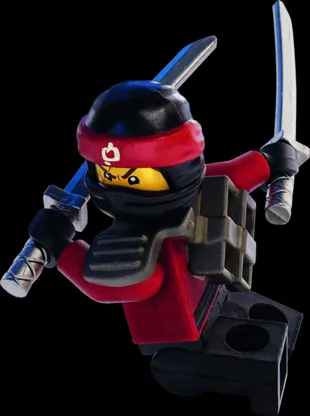

In [41]:
Kai_img = "https://www.superherodb.com/gallery2/075/78/7881.webp"
Disp.Image(requests.get(Kai_img).content)

In [42]:
display(hero_text.text[713])
print()
most_important_terms(713, cool2)

'Kai\'s attitude is more serious, like Cole in the TV show. Despite this, he is very compassionate and approachable, as he is "always ready with a hug." Much like his own TV show counterpart, Kai is possibly impulsive, enjoys fighting enemies, and is loyal and protective of those he cares about, especially his teammates. Unlike his TV counterpart (beside the alternate face on his figurine), he seems to be curious or perhaps more sassy. He also appears to enjoy describing things with a variety of onomatopoeia. Kai wields a pair of katanas in the trailers, but he may be skillful with other weapons, though these are his favorite weapons. He and the other Ninja have Elemental Powers like their TV show counterparts, allowing him to create and manipulate fire. As seen in the trailers, Kai\'s vehicle has weapons that are fire-based like the flamethrower in his mech. Like the other Ninja, he is a master builder.'


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
approachable         0.06791984816317684  0.41562268           0.02822902941245572
onomatopoeia         0.06791984816317684  0.053381793          0.0036256832888879676
sassy                0.06791984816317684  0.53244966           0.036163900244126704
figurine             0.061452422800610744 0.20427677           0.012553302460095318
compassionate        0.05498499743804464  0.28535867           0.015690445594464374
impulsive            0.05290295151224754  0.3019842            0.015975855010809458
builder              0.05120179612473055  0.15518515           0.007945758315622588
flamethrower         0.05120179612473055  0.1464904            0.007500571342560435
trailer              0.048517572075478556 0.19864953           0.009637992678114526
hug                  0.04741859481141646  0.27284414           0.01293788552033434
mech                 0.04329606437597063  0.18362944           0.0079504

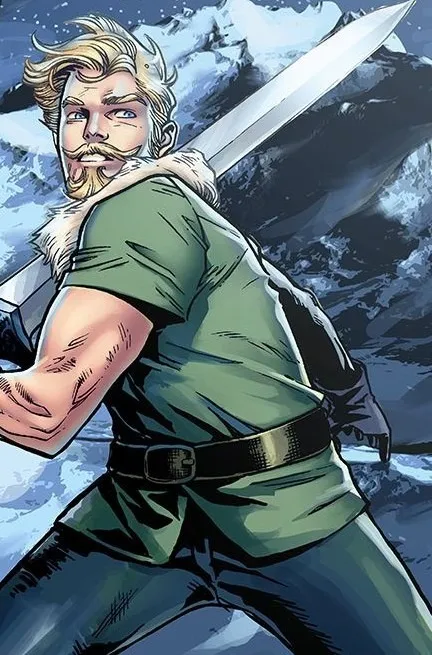

In [43]:
Fandral_img = "https://www.superherodb.com/gallery2/075/95/9511.webp"
Disp.Image(requests.get(Fandral_img).content)

In [44]:
display(hero_text.text[465])
print()
most_important_terms(465, cool2)

"Fandral the Dashing was a charter member of the Warriors Three, a trio of Asgardian adventurers consisting of himself, Hogun the Grim, and Volstagg the Voluminous. Fandral was a strong and brave and a good friend to Thor. He fought in countless battles with his friends, to preserve and protect his people. He has been described as one of the most good-looking Asgardians which along with his charm, gave him the reputation as a ladies' man. Besides his looks, Fandral is also known for his skills in swordsmanship and bravery. He and Thor first met when the Warriors Three joined the Thunder God on an expedition to restore the Odinsword that had become cracked.Allegedly, Volstagg the Staggeringly Perfect led the youth Hogun the Good, Fandral the Quite Plain, Thor and Loki in Hel, fighting against all of its hordes for forty days and nights. Eventually Hogun was hurt and forced to retreat, helped by Fandral. Due to the battle, Hogun the Good became Hogun the Grim, and for some reason, Fandra


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
Dashing              0.06705253364967637  0.36166626           0.02425063921275286
staggeringly         0.06705253364967637  0.21384093           0.014338576265406399
voluminous           0.06705253364967637  0.19335152           0.012964709441025173
Odinsword            0.06066769521911369  nan                  nan
Plain                0.06066769521911369  0.30313048           0.0183902274307171
Hogun                0.056932804164071205 nan                  nan
Hel                  0.054282856788551014 0.09350801           0.0050758820561565806
Fandral              0.054282856788551014 nan                  nan
expedition           0.05222739791643635  0.15747079           0.008224289741783642
Good                 0.049128026055093685 0.46013132           0.022605343348866283
Perfect              0.049128026055093685 0.48676783           0.023913942559585726
Volstagg             0.04912802605509368

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


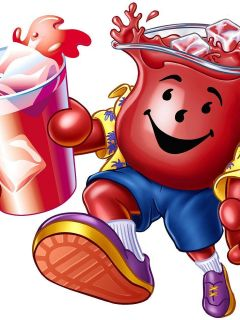

In [45]:
Kool_Aid_Man = df.query("name == 'Kool-Aid Man'")
Kool_Aid_Man_img = "https://www.superherodb.com" + Kool_Aid_Man['img'].values[0]
Disp.Image(requests.get(Kool_Aid_Man_img).content)

In [46]:
display(hero_text.text[758])
print()
most_important_terms(758, cool2)

'Before he was officially the Kool-Aid Man in 1975, he was the “Pitcher Man”. The Pitcher Man was created in 1954 by Marvin Plotts, an art director for a New York-based advertising agency. General Foods had just purchased Kool-Aid from the drink’s creator Edwin Perkins the year before, and Plotts was charged with drafting a concept to illustrate the copy message: “A 5-cent package makes two quarts. " Working from his Chicago home on a cold day, Potts watched as his young son traced smiley face patterns on a frosty windowpane," recounts Sue Uerling, marketing and communications director for Hastings Museum of Natural and Cultural History. This inspired Marvin Plotts to create a beaming glass pitcher filled with flavorful drink: the Pitcher Man. From there on the joyful pitcher was on all the Kool-Aid’s advertisements. the voice of the man is John Fickley. In 1975 Kraft Foods created the character’s first costume with arms and legs. He also became more of an action figure in commercials 


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
Aid                  0.060925765262218344 0.09816323           0.005980670042842486
Cola                 0.060925765262218344 0.16447066           0.010020500683934301
Cultural             0.060925765262218344 0.32935748           0.020066356211786734
Fickley              0.060925765262218344 nan                  nan
Fierce               0.060925765262218344 0.4030141            0.024553942066321964
Foods                0.060925765262218344 0.16801979           0.010236734070311167
Kool                 0.060925765262218344 0.40055874           0.024404347760913256
Kraft                0.060925765262218344 0.057796296          0.0035212835468094094
Perkins              0.060925765262218344 0.014764874          0.000899561262209263
Pitcher              0.060925765262218344 0.14530031           0.008852532812956126
Plotts               0.060925765262218344 nan                  nan
Uerling             

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


And the new ranking has some intriguing results. Apart from Kai, GPL, Lyold(in two entries), Killow and Masako from the LEGO universe get into the top 10. Does LEGO have a secret formula to make its characters look cool in descriptions? On the surface of words the cool factor is not apparent. On the other hand, Jack Kirby, the creator or co-creator of many classics like Avengers, X-Men and Fantastic Four gets into seventh with a long description.

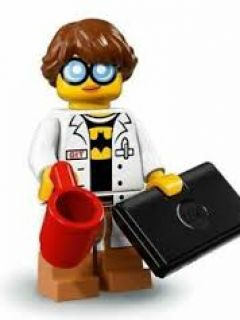

In [47]:
GPL = df.query("name == 'GPL'")
GPL_img = "https://www.superherodb.com" + GPL['img'].values[0]
Disp.Image(requests.get(GPL_img).content)

In [48]:
display(hero_text.text[531])
print()
most_important_terms(531, cool2)

'The IT Guys had the idea of making the Garma Mecha Man and help Garmadon conquer the city. Later, Garmadon used them in order to spy on his brother. They found out that he was going into the jungle so Garmadon left his base in order to track them down. It is unknown what happened to them after that. Mostly intelligence'


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
Guys                 0.06458517110288423  0.45356318           0.029293455815291573
Garma                0.060609108109732086 nan                  nan
Mecha                0.05778804652096598  0.22416733           0.012954192213170256
jungle               0.04250860316096824  0.2915481            0.012393302616760193
Garmadon             0.037708006159823185 nan                  nan
spy                  0.030297795833309066 0.24046816           0.007285655195427501
conquer              0.029044239047321126 0.24527624           0.007123861819641377
idea                 0.028050358455296194 0.4574217            0.012830842376055569
intelligence         0.024034992091186022 0.19812399           0.0047619085685221855
happen               0.022117229415213515 0.30731177           0.006796884992075967
city                 0.0200328140947789   0.28917164           0.00579292162756618
track                

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


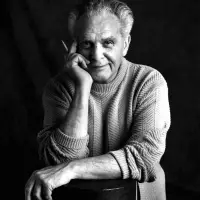

In [49]:
Jack_Kirby_img = "https://www.superherodb.com/gallery2/025/41/4110.webp"
Disp.Image(requests.get(Jack_Kirby_img).content)

In [50]:
display(hero_text.text[661])
print()
most_important_terms(661, cool2)

"Born and raised in the Lower East Side, Jack Kirby (born Jacob Kurtzberg) created or co-created some of the most enduring characters and stories in comics (Captain America, Avengers, Hulk, X-Men, Fantastic Four, Silver Surfer, Darkseid, among hundreds of others). In addition to revolutionizing such comic book genres as crime, war, and superheroes, Kirby also co-invented romance comics with his partner Joe Simon. Kirby’s 1960s work with Marvel’s Stan Lee (who dubbed Kirby “King”) may be his most well-known. Another Kirby legacy is that he almost single-handedly defined the visual language of comic books with his dynamic page layouts portraying exaggerated anatomy, heartfelt emotion, explosive movement, and cosmic wonder. Kirby died in 1994 at age 76. Evidence of his work and influence surrounds us today, not only in comics but also in television and movies In The Beginning… In August of 1917, Rose and Ben Kurtzberg, two immigrants from Galicia in what is now Poland welcomed their first


term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
BBR                  0.030059266935080042 -0.07996785          -0.0024037749180101484
Barbarian            0.030059266935080042 0.21690407           0.006519977458278463
Barnum               0.030059266935080042 -0.033380877         -0.0010034046990812365
Books                0.030059266935080042 0.2535265            0.007620821003382681
Boop                 0.030059266935080042 0.18722442           0.005627828755168982
Bund                 0.030059266935080042 -0.020908857         -0.0006285049067895288
Cartoons             0.030059266935080042 0.2754124            0.008278695164383166
Classics             0.030059266935080042 0.35925016           0.010798796397941459
Comic                0.030059266935080042 0.36084726           0.010846804247248844
Crestwood            0.030059266935080042 0.014246441          0.00042823758563578074
Ditko                0.030059266935080042 -0.009791492         

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


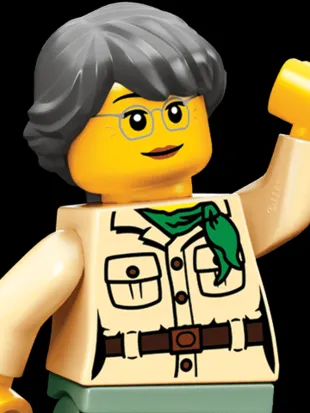

In [51]:
Misako_img = "https://www.superherodb.com/gallery2/075/78/7892.webp"
Disp.Image(requests.get(Misako_img).content)

In [52]:
display(hero_text.text[891])
most_important_terms(891, cool2)

"As a young woman, Misako met the sons of the First Spinjitzu Master; Garmadon and Wu. She befriended the brothers, and was even taught Spinjitzu by Wu. Though she was initially inclined toward Wu, a letter she received from Garmadon swayed her to choose to marry him instead. The two spent many happy years together, and eventually had a son named Lloyd. Eventually, Garmadon succumbed to the evil growing inside him as a result of his bite by The Great Devourer and was cast into the Underworld after a battle against Wu. Realizing that Lloyd would become the legendary Green Ninja, Misako left him at Darkley's Boarding School for Bad Boys so that she could research the prophecy in the hopes of preventing it. Misako is Garmadon’s wife, Lloyd’s mother, and the love of Master Wu’s life. She was tricked into marrying Garmadon and regrets the years she missed with Wu. Intelligent and accomplished, Misako worked as an archaeologist at the NINJAGO® Museum of History and is also a Spinjitzu master

term                 TF-IDF Score         Cosine Similarity    TF-IDF*Cosine Similarity
Darkly               0.06418390653806137  0.2957853            0.018984656556572246
NINJAGO              0.06418390653806137  nan                  nan
archaeological       0.06418390653806137  0.16499858           0.010590253183787823
Boarding             0.05807222289566651  0.15743129           0.009142384937711329
Darkley              0.05807222289566651  nan                  nan
inclined             0.05807222289566651  0.29268578           0.016996913677369527
mythology            0.05196053925327166  0.2471848            0.012843855405601755
academic             0.049993016581721235 0.17089221           0.008543417028956314
archaeologist        0.04838543350619979  0.14359596           0.006947952954163725
Boys                 0.045848855610876815 0.33418396           0.015321952182376157
Misako               0.045848855610876815 nan                  nan
overjoyed            0.0438813329393263

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


# Fourth Attempt: Compare Only the Top Similarity Scoring Terms

Despite Kirby's entry, most of the high similarity scoring texts are relatively short, reflecting that even if TD-IDF is used, it cannot overcome the dilution problem of long documents effectively. An alternative approach is to concentrate just on the top similarity scoring terms in each document of description, instead of getting the similarity score from the vector of the whole document. In the following implementation, I get the top 10 scoring terms with the new "cool" vector and then take the average in each document as a basis of comparison. To avoid the case that some descriptions may score high simply because they have repeated mentions of certain fairly high scoring terms such as "look" and "kind", I only count the unique terms. In this way, descriptions which have more high similarity terms with the new "cool" vector would get higher scores, but long documents would have advantage as they are more likely to include various words related to "cool".

In [53]:
def top_n_similarity_score(tokens_list, target, n):
    target_score_list=[cosine_similarity(nlp(word).vector, target) if np.any(nlp(word).vector) else 0 for word in set(tokens_list)]
    target_score_list.sort(reverse=True)
    if len(target_score_list) >= n:
        return sum(target_score_list[:n])/n
    else:
        return sum(target_score_list)/len(target_score_list)

In [54]:
docs_top_10_score=[top_n_similarity_score(token_list, cool2, 10) for token_list in docs]

In [55]:
pd.Series(docs_top_10_score).sort_values(ascending=False)

616     0.541959
630     0.541959
835     0.541959
1424    0.541959
1195    0.541743
          ...   
876     0.087689
537     0.073837
926     0.061235
59      0.055142
1162    0.053617
Length: 1450, dtype: float64

In [56]:
hero_text['cool_score4']=pd.Series(docs_top_10_score)
hero_text.sort_values(by='cool_score4', ascending=False).head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,name,text,cool_score,cool_score2,cool_score3,cool_score4
616,Hulk,Robert Bruce Banner was the son of an alcoho...,0.538590,0.471117,0.437627,0.541959
630,Immortal Hulk,Childhood Trauma Robert Bruce Banner was the s...,0.539076,0.468902,0.437131,0.541959
835,Maestro Hulk,Childhood Trauma Robert Bruce Banner was the s...,0.539449,0.468811,0.437468,0.541959
1424,World Breaker Hulk,Childhood Trauma Robert Bruce Banner was the s...,0.539449,0.468811,0.437468,0.541959
1195,Sonic The Hedgehog,Past Not much is known about Sonic's early lif...,0.558913,0.527919,0.478624,0.541743
393,Devilman,Transformation Akira is first seen walking hom...,0.542339,0.527686,0.471312,0.535343
582,Heart Of The Monster Hulk,NA The Hulk is one of the most powerful beings...,0.535973,0.471837,0.392193,0.530370
1421,Wonder Woman,Origin Wonder Woman did not keep her identity...,0.532390,0.464344,0.469892,0.530018
467,Fëanor,Fëanor drew so much of Míriel's life energy w...,0.501195,0.389129,0.442618,0.530011
661,Jack Kirby,"Born and raised in the Lower East Side, Jack K...",0.563324,0.522332,0.526997,0.528659


After this change of approach, some of the more well known names finally emerged, although with some surprise. According to this measurement, Hulk is the coolest superhero. In fact five versions of Hulk, each with very similar descriptions, get into the top 10. The cool related terms in descriptions of the Hulks include "awesome", "amazing", "style", "look", "unique", "fantastic". "great", "truly", "incredibly" and "love".

In [57]:
def display_content_and_top_words(index, target):
    token_similarity=pd.DataFrame([token, cosine_similarity(nlp(token).vector, target)] for token in set(docs[index]) if np.any(nlp(token).vector))
    token_similarity.columns=['token','similarity_score']
    display(hero_text.text[index])
    display(token_similarity.sort_values(by='similarity_score', ascending=False).head(10))

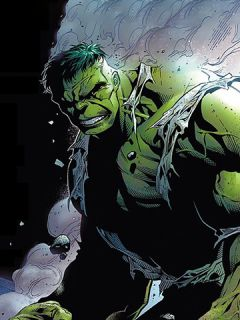

In [58]:
Hulk = df.query("name == 'Hulk'")
Hulk_img = "https://www.superherodb.com" + Hulk['img'].values[0]
Disp.Image(requests.get(Hulk_img).content)

In [59]:
display_content_and_top_words(616, cool2)

'  Robert Bruce Banner was the son of an alcoholic who deeply hated him. Banner\'s mother showed much affection for her child, who returned her love, but this only served to fuel his father\'s rage. Dr. Brian Banner was an atomic physicist who worked on producing clean nuclear power as an energy source, but he was afraid his exposure to it mutated his son\'s genes. Bruce showed signs of high intelligence at an early age which strengthened his father\'s belief. Brian became abusive to Bruce and when his mother intervened, Brian murdered her. He frightened Bruce to keep quiet, but his own bragging landed him in a psychiatric institute.   As a child Bruce was withdrawn, possibly developing a split personality to help deal with his pain and rage. His only happiness came from spending time with his cousin Jennifer Walters. Bruce found it hard to develop friendships and often found himself on the receiving end of physical abuse at the hands of school bullies. One such incident sparked him to

,token,similarity_score
787,awesome,0.623981
149,amazing,0.574151
770,style,0.542009
243,look,0.538010
964,unique,0.533982
260,Fantastic,0.530717
435,great,0.521193
807,truly,0.520816
883,incredibly,0.519549
441,love,0.515183


In [60]:
display_content_and_top_words(630, cool2)

'Childhood Trauma Robert Bruce Banner was the son of an alcoholic who deeply hated him. Banner\'s mother showed much affection for her child, who returned her love, but this only served to fuel his father\'s rage. Dr. Brian Banner was an atomic physicist who worked on producing clean nuclear power as an energy source, but he was afraid his exposure to it mutated his son\'s genes. Bruce showed signs of high intelligence at an early age which strengthened his father\'s belief. Brian became abusive to Bruce and when his mother intervened, Brian murdered her. He frightened Bruce to keep quiet, but his own bragging landed him in a psychiatric institute. As a child Bruce was withdrawn, possibly developing a split personality to help deal with his pain and rage. His only happiness came from spending time with his cousin Jennifer Walters. Bruce found it hard to develop friendships and often found himself on the receiving end of physical abuse at the hands of school bullies. One such incident s

,token,similarity_score
809,awesome,0.623981
153,amazing,0.574151
792,style,0.542009
248,look,0.538010
993,unique,0.533982
266,Fantastic,0.530717
449,great,0.521193
830,truly,0.520816
911,incredibly,0.519549
456,love,0.515183


After four of the Hulks, Sonic the Hedgehog and the Devilman claim the highest positions. Sonic's high scoring terms include "authentic", "amazing" and "unique", while Devilman's description refers to "keep everything cool".

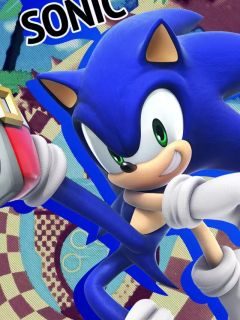

In [61]:
Sonic_the_Hedgehog = df.query("name == 'Sonic The Hedgehog'")
Sonic_the_Hedgehog_img = "https://www.superherodb.com" + Sonic_the_Hedgehog['img'].values[0]
Disp.Image(requests.get(Sonic_the_Hedgehog_img).content)

In [62]:
display_content_and_top_words(1195, cool2)

'Past Not much is known about Sonic\'s early life. He was born on Christmas Island with his abnormal ability to run at super-speed, but his love for adventure eventually called him away from his home. Since then, he has spent his life traveling the globe, driven by his restless spirit, in search of adventures to satisfy his thirst for thrills. At some point, Sonic met Dr. Ivo Robotnik and they became enemies. Sonic would subsequently fight Robotnik in an untold number of confrontations as the scientist attempted time and again to conquer the world, with Sonic foiling the doctor\'s plans each time. Despite their many battles, Sonic did not really account for his adversary. Sonic the Hedgehog (1991) In Sonic the Hedgehog, Sonic heard the news about Dr. Robotnik invading South Island after the doctor had discovered some powerful relics, called the "Chaos Emeralds", which were hidden on the island and which he now sought to produce weapons of mass destruction. Annoyed by Robotnik\'s persev

,token,similarity_score
1245,authentic,0.641879
241,amazing,0.574151
1435,style,0.542009
427,look,0.538010
1767,unique,0.533982
1540,funny,0.523466
768,great,0.521193
433,Great,0.521193
786,love,0.515183
1412,beautiful,0.506362


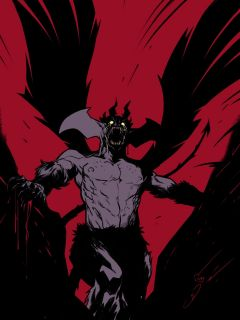

In [63]:
Devilman = df.query("name == 'Devilman'")
Devilman_img = "https://www.superherodb.com" + Devilman['img'].values[0]
Disp.Image(requests.get(Devilman_img).content)

In [64]:
display_content_and_top_words(393, cool2)

'Transformation Akira is first seen walking home from his first day at his new school with Miki Makimura whose family he had recently moved in with. One the way however they are stopped by Ken,\xa0Go and Dosu-Roku\xa0three gang member, all of whom were all attracted to Miki and start teasing the two, Miki gets angered by them whilst Akira tries to keep everything cool, Miki slaps Ken and Meriken-Jo but is grabbed by a furious Dosu-Roku starts to try and undress her, whilst Akira is held back by the other two, luckily they are saved by the sudden and mysterious intervention of Ryo Asuka who threatens the gang with a highly illegal sawed-off shotgun. Ryo says that he needs to speak to Akira privately and Miki is forced to walk back by herself. On the way to Ryo\'s home, he reveals that his father committed suicide after killing his dog John\xa0and then attempted to kill Ryo, as they arrive at his home he tells Akira that his father had been possessed by a Demon. At first, Akira didn\'t b

,token,similarity_score
767,cool,0.723243
773,look,0.538010
123,kind,0.536982
396,great,0.521193
635,truly,0.520816
430,love,0.515183
502,beautiful,0.506362
783,Crazy,0.505194
497,true,0.499678
400,perfect,0.486768


# Conclusion

Are Red Mist, Kai and Hulk really the coolest superheros? The question of "what is cool?" can draw many different opinions itself, perhaps more so with which superhero is the coolest. The four attempts described above include some unconventional approaches, and the answers arrived may not agree with many people, nonetheless they are judged purely on the basis of textual descriptions, with some quantifiable criteria. 

The application of word embedding vectors as a basis of comparison has an advantage over word matching that it might be better at capturing vague ideas such as "cool", but just like counting the appearance of words, it is far from perfect. The cool words in the history part of the description of superhero may be referring to others rather than the superhero himself/herself, and "look" the verb may be counted incorrectly as "look" the noun as one aspect of "cool". Suggestions for improvement or wholly different approaches are welcomed.